In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Data Parsing

In order to model age demographics, we will follow a kind of 'bucket' based modeling, where the population will be divided into buckets based on age. As the years go by, members flow from one bucket to another. Each bucket has an associated birth and death rate as well (the birth rate only applies to newborn, while the death rate applies to all buckets, at varying values) - the addition of birth and death rates will be handled in the next section. The collection of buckets will comprise the main state of the simulation, the age demographic based population count.

Using Census data (age demographic data), we will construct our initial population bucket states. The states will be organized into a Series object, with each index corresponding to a certain age. The index will be equivalent to age value of each bucket (the last index of the buckets will be equivalent to cap-off age, where the oldest of the population will be bunched together).

In [202]:
init_age_data = sio.loadmat('AgeDemographicData.mat')['AgeDemographicData']
init_data = pd.Series(init_age_data[:,1], index=init_age_data[:,0])

In [203]:
state = pd.Series()
buckets = pd.Series(index = np.linspace(0,100,101,dtype=int))
for i in init_data.index:
    if i == init_data.index[0]:
        state['total'] = init_data[i]
        k = i
    else:
        pop_value = init_data[i]/(i-k)
        for j in range(k, i):
            if j <= 100:
                buckets[j]=pop_value
            else:
                buckets[100] = pop_value + buckets[100]
        k = i
state['buckets'] = buckets

total                                                 304280
buckets    0      4286.800000
1      4286.800000
2      4...
dtype: object
304280
0      4286.800000
1      4286.800000
2      4286.800000
3      4286.800000
4      4286.800000
5      4157.000000
6      4157.000000
7      4157.000000
8      4157.000000
9      4157.000000
10     3978.600000
11     3978.600000
12     3978.600000
13     3978.600000
14     3978.600000
15     4217.200000
16     4217.200000
17     4217.200000
18     4217.200000
19     4217.200000
20     4230.800000
21     4230.800000
22     4230.800000
23     4230.800000
24     4230.800000
25     4290.600000
26     4290.600000
27     4290.600000
28     4290.600000
29     4290.600000
          ...     
71     1787.200000
72     1787.200000
73     1787.200000
74     1787.200000
75     1436.200000
76     1436.200000
77     1436.200000
78     1436.200000
79     1436.200000
80     1156.600000
81     1156.600000
82     1156.600000
83     1156.600000
84     1156.600000
85

# Model Construction

The model's main focus is to create an update function that can handle the change in longevity. This includes developing the concept of birth and death rates. In this 'bucket modeling' system, this means the following:
  * The birth rate will be assumed as dependent on a simplistic model for birth rate - the simulation will run from the start of the data (2010) for 60 years, so that those in the elderly range (65+) will be unaffected by the birth rate assumption. 
  * The death rate will be determined by a function of the age group involved, and will change (increase) as the ages get older.

With this in mind, the proposed update function will have the following structure:
  * Enter bucket
    * Check if the bucket is the last bucket:
      * Only apply death rate to this bucket
      * Add population number from previous bucket to this bucket
    * Check if the bucket is the first bucket:
      * Apply the death rate to the current amount in the first bucket
      * Store resulting population number into interim variable
      * Apply the birth rate
      * Set the amount born as new value for first bucket
    * If neither:
      * Apply death rate to the current bucket amounts
      * Store resulting population number into interim variable
      * Receive population number of previous bucket from another interim variable, set equal to new population bucket amount
    * Exit bucket
  * Loop through next buckets till completion of bucket updates

In [204]:
system = pd.Series({'t_0': 2010, 't_end': 2070,
                    'death':pd.Series(np.zeros(101)+0.01, index=np.linspace(0,100,101, dtype=int)),
                    'birth': 0.012})

In [205]:
def update_buckets(t, state,params):

    state['buckets'] = state['buckets'] - state['buckets'] * params['death']
    
    interim_buckets = pd.concat([pd.Series(params['birth'] * state['total']), 
                                state['buckets'][0:-1]], ignore_index = True)
    interim_buckets[interim_buckets.index[-1]] = interim_buckets[interim_buckets.index[-1]] + state['buckets'][-1:]
    
    state['buckets'] = interim_buckets
    state['total'] = interim_buckets.sum()
    return state

# Simulation

Using the update function defined in the **Model Construction** section, the simulation is defined as moving through a period of time, updating the buckets with each timestep. The results of each update will be stored in a Dataframe object, so that the evolution of each individual bucket can be seen in the end; a column will also be added for the total population amount.

In [215]:
def run_simulation(state, system, update_func):
    t_interval = system['t_end'] - system['t_0'] + 1
    t_range = np.linspace(system['t_0'], system['t_end'], t_interval, dtype = int)
    
    results = pd.DataFrame(columns = np.concatenate((np.array(state['buckets'].index),
                                                      np.array('total')), axis = None),
                           index = t_range)
    
    for t in np.linspace(system['t_0'], system['t_end'], t_interval, dtype = int):
        state = update_func(t, state, system)
        results.iloc[t-system['t_0']] = pd.concat([state['buckets'], 
                                                   pd.Series(state['total'])], 
                                                  ignore_index = True).values
    return results

# Results

There are three graphs to indicate the results: the evolution of total population over time, the evolution of the elderly population over time, and the age demographics in the final year of simulation (in a histogram). These will provide a snapshot of the model's projection for the effect of increasing longevity on the population.

Text(0.5,1,'Population demographics after 60 years')

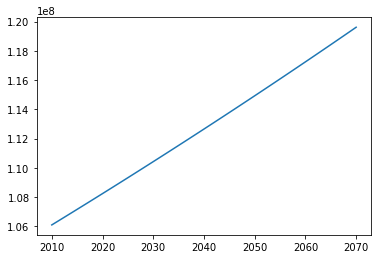

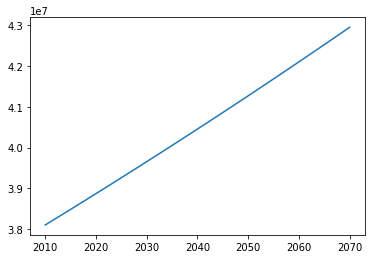

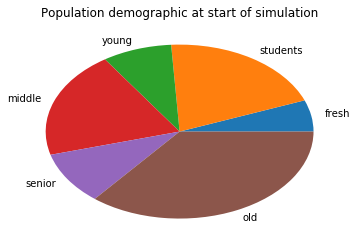

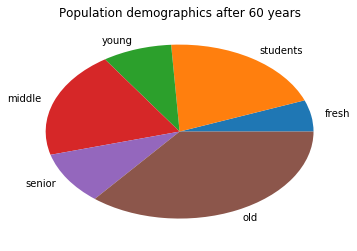

In [259]:
res = run_simulation(state, system, update_buckets)

fresh_pop = res.loc[:,'0':'4'].sum(axis = 1)
student_pop = res.loc[:,'5':'24'].sum(axis = 1)
young_pop = res.loc[:,'25':'34'].sum(axis = 1)
middle_pop = res.loc[:,'35':'64'].sum(axis = 1)
senior_pop = res.loc[:,'65':'84'].sum(axis = 1)
geriatric_pop = res.loc[:,'85':'100'].sum(axis = 1)
total_pop = res.loc[:,'total']

plt.figure()
total_pop.plot()

plt.figure()
geriatric_pop.plot()

plt.figure()
plt.pie([fresh_pop[fresh_pop.index[0]], student_pop[student_pop.index[0]],
         young_pop[young_pop.index[0]], middle_pop[middle_pop.index[0]],
         senior_pop[senior_pop.index[0]], geriatric_pop[geriatric_pop.index[0]]],
        labels = ['fresh', 'students', 'young', 'middle', 'senior', 'old'])
plt.title('Population demographic at start of simulation')

plt.figure()
plt.pie([fresh_pop[fresh_pop.index[-1]], student_pop[student_pop.index[-1]],
         young_pop[young_pop.index[-1]], middle_pop[middle_pop.index[-1]],
         senior_pop[senior_pop.index[-1]], geriatric_pop[geriatric_pop.index[-1]]],
        labels = ['fresh', 'students', 'young', 'middle', 'senior', 'old'])
plt.title('Population demographics after 60 years')

# Validation

Because this model deals in the space of future population projection, there are two ways to validate the model: start simulation in the past, such that it can be compared with actual data, or compare the data against projections provided by institutes such as the US Census or the UN DESA. These will provide a sense of the model's reasonability. 

# Interpretation

The model's results are indicative of the effects of increasing longevity on the population. Compared to Japan, which is already experiencing the effects of an 'aging population', the model shows that ----. In addition to simply predicting the number of elderly that will be in the world, the model also serves a basis for improvements/alterations in public policy geared towards and effecting the elderly population, such as policies for Social Security funds management, and hospital grant allocation.